In [ ]:
# import the necessary modules
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [150]:
#reading the csv file as a pandas dataframe
article = pd.read_csv("CompleteNewsData_136M.csv")

In [151]:
# printing the column names of the data frame
print (article.columns)

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'id', u'heading', u'link_article',
       u'abstract_text', u'full_article', u'image_url', u'author', u'date_',
       u'category', u'domain', u'epoch', u'url_hash', u'content_hash'],
      dtype='object')


In [152]:
# making a new dataframe containing only the necessary columns
art = article[['id','heading','link_article','abstract_text','full_article']].copy()

In [153]:
#checking the dataframe to have the desired columns
print (art.columns)

Index([u'id', u'heading', u'link_article', u'abstract_text', u'full_article'], dtype='object')


In [154]:
# printing the dat frame size
print(art.shape)

(38904, 5)


In [155]:
# reading the content for first cell of full article
art.at[0,'full_article']

'paul carr may 18 2015did miss ussarah traveling last week meaning pandolive back refreshed rejuvenated excited bring brand new show live pandolive studiothis week well talking uber special guestemily guendelsberger senior staff writer forphiladelphia city paperwho went undercover uber driver lived tell tale tell tale tonights showclick listen live'

In [156]:
art['full_article'].iloc[0]

'paul carr may 18 2015did miss ussarah traveling last week meaning pandolive back refreshed rejuvenated excited bring brand new show live pandolive studiothis week well talking uber special guestemily guendelsberger senior staff writer forphiladelphia city paperwho went undercover uber driver lived tell tale tell tale tonights showclick listen live'

In [157]:
# making saperate list for each columns to easily tackle
full_art = art['full_article'].tolist()
ident = art['id'].tolist()
heading = art['heading'].tolist()
linkart = art['link_article'].tolist()

In [158]:
# taking only 1000 initial entries to reduce the training time and easy visualization
full = full_art[:1000]
iid = ident[:1000]
head = heading[:1000]
link = linkart[:1000]

In [159]:
# import nltk module for text tokenization and removing stopwords
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [160]:
# downloading if necessary the english language stopwords for nltk module
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/mirk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [161]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [162]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [163]:
# list for containing the tokenized and stemmed entries of our 'full' list
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in full:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'full', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [164]:
# creating new dataframe to hold tokenized word indexes with stemmed word
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are238724 items in vocab_frame


In [165]:
print (vocab_frame.head())

           words
paul        paul
carr        carr
may          may
2015did  2015did
miss        miss


In [166]:
# creating the tf-idf vector matrix for our tokenized and stemmed data
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(full) #fit the vectorizer to full article

print(tfidf_matrix.shape)

CPU times: user 11 s, sys: 46.4 ms, total: 11.1 s
Wall time: 10.9 s
(1000, 38)


In [167]:
#holding the feature names from the tf-idf matrix in terms
terms = tfidf_vectorizer.get_feature_names()

In [168]:
# making a distance matrix based on cosine similarity 
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [169]:
# applying k means clustering
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

#from sklearn.metrics import silhouette_samples, silhouette_score
#silhouette_avg = silhouette_score(tfidf_matrix, cl_label)
#print(silhouette_avg)
#0.0737703042883 cluster = 5
#0.0852698815177 cluster = 12
#Choose 5 for easy visualization

CPU times: user 459 ms, sys: 0 ns, total: 459 ms
Wall time: 458 ms


In [170]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

#joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [171]:
news = { 'identity': iid, 'heading': head, 'text': full, 'cluster': clusters, 'link': link }
# creating data frame to hold data columns indexed with clusters
frame = pd.DataFrame(news, index = [clusters] , columns = ['identity', 'heading', 'cluster', 'link'])

In [172]:
# number of entries in each clusters
frame['cluster'].value_counts()

2    247
3    232
1    220
0    186
4    115
Name: cluster, dtype: int64

In [174]:
# printing the to 6 words of each cluster and headings for each entry of a particlular cluster
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d heading:" % i, end='|')
    for title in frame.ix[i]['heading'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: played, team, said, runs, year, good,

Cluster 0 heading:| two tango shah rukh khan abram get jiggy kkr match, wiggins leads nba allrookie team, selectors opt tried tested squad bangladesh tour, jose mourinho outraged cesc fabregas red card, gaana message, nba cavs survive without lebron beat spurs 9795, contador hurts leg henderson wins first stage, idiots guide dinner, idowu miss worlds late arriving baby, chills amp thrills supper, richard hadlee backs new zealand add englands woes, joe root named englands cricketer year, pakistan welcome zimbabwe international cricket returns amidst tight security, justin langer rules india england jobs western australia extention, chelsea fc manager jose mourinho outraged fabregas red card, anil kumbleled icc panel recommends daynight test matches, epl champions chelsea fc suffer worst loss season, ipl took chance david warner worked says mitchell mcclenaghan, zimbabwe tour pakistan begins amidst high stake

In [175]:
# dimension reduction to 'two' dimension for plotting a graph using matplotlib
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
#  also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [176]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'point, share, monday, days, reporter, week', 
                 1: 'said, state, year, new, told, monday', 
                 2: 'played, team, said, runs, year, good', 
                 3: 'using, says, new, people, likely, time', 
                 4: 'company, said, new, making, year, included'}

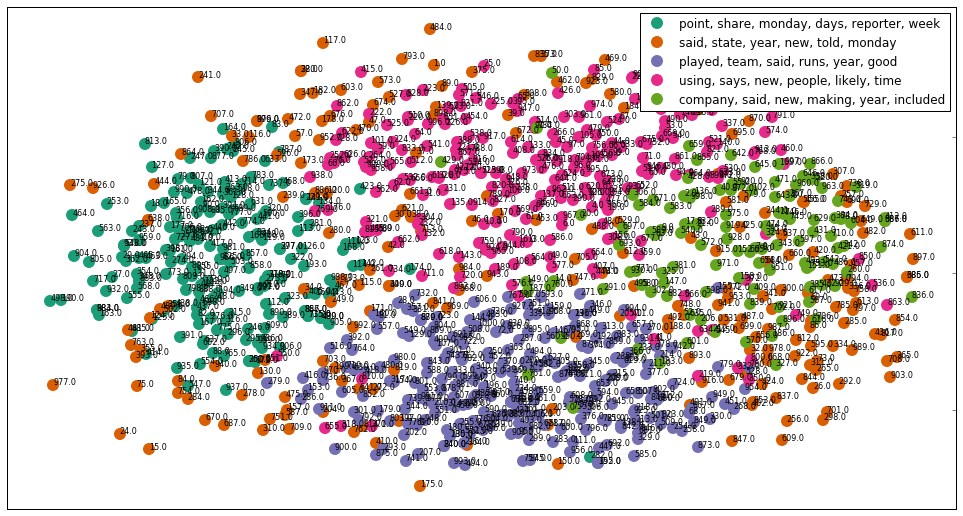

In [177]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and heading
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, identity=iid)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the article id in total 1000 ids
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['identity'], size=8)  

    
    
plt.show()

In [181]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [186]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, heading=head)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,8)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.heading]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)


In [189]:
plt.close()
# hower mouse over above data points graph to view heading

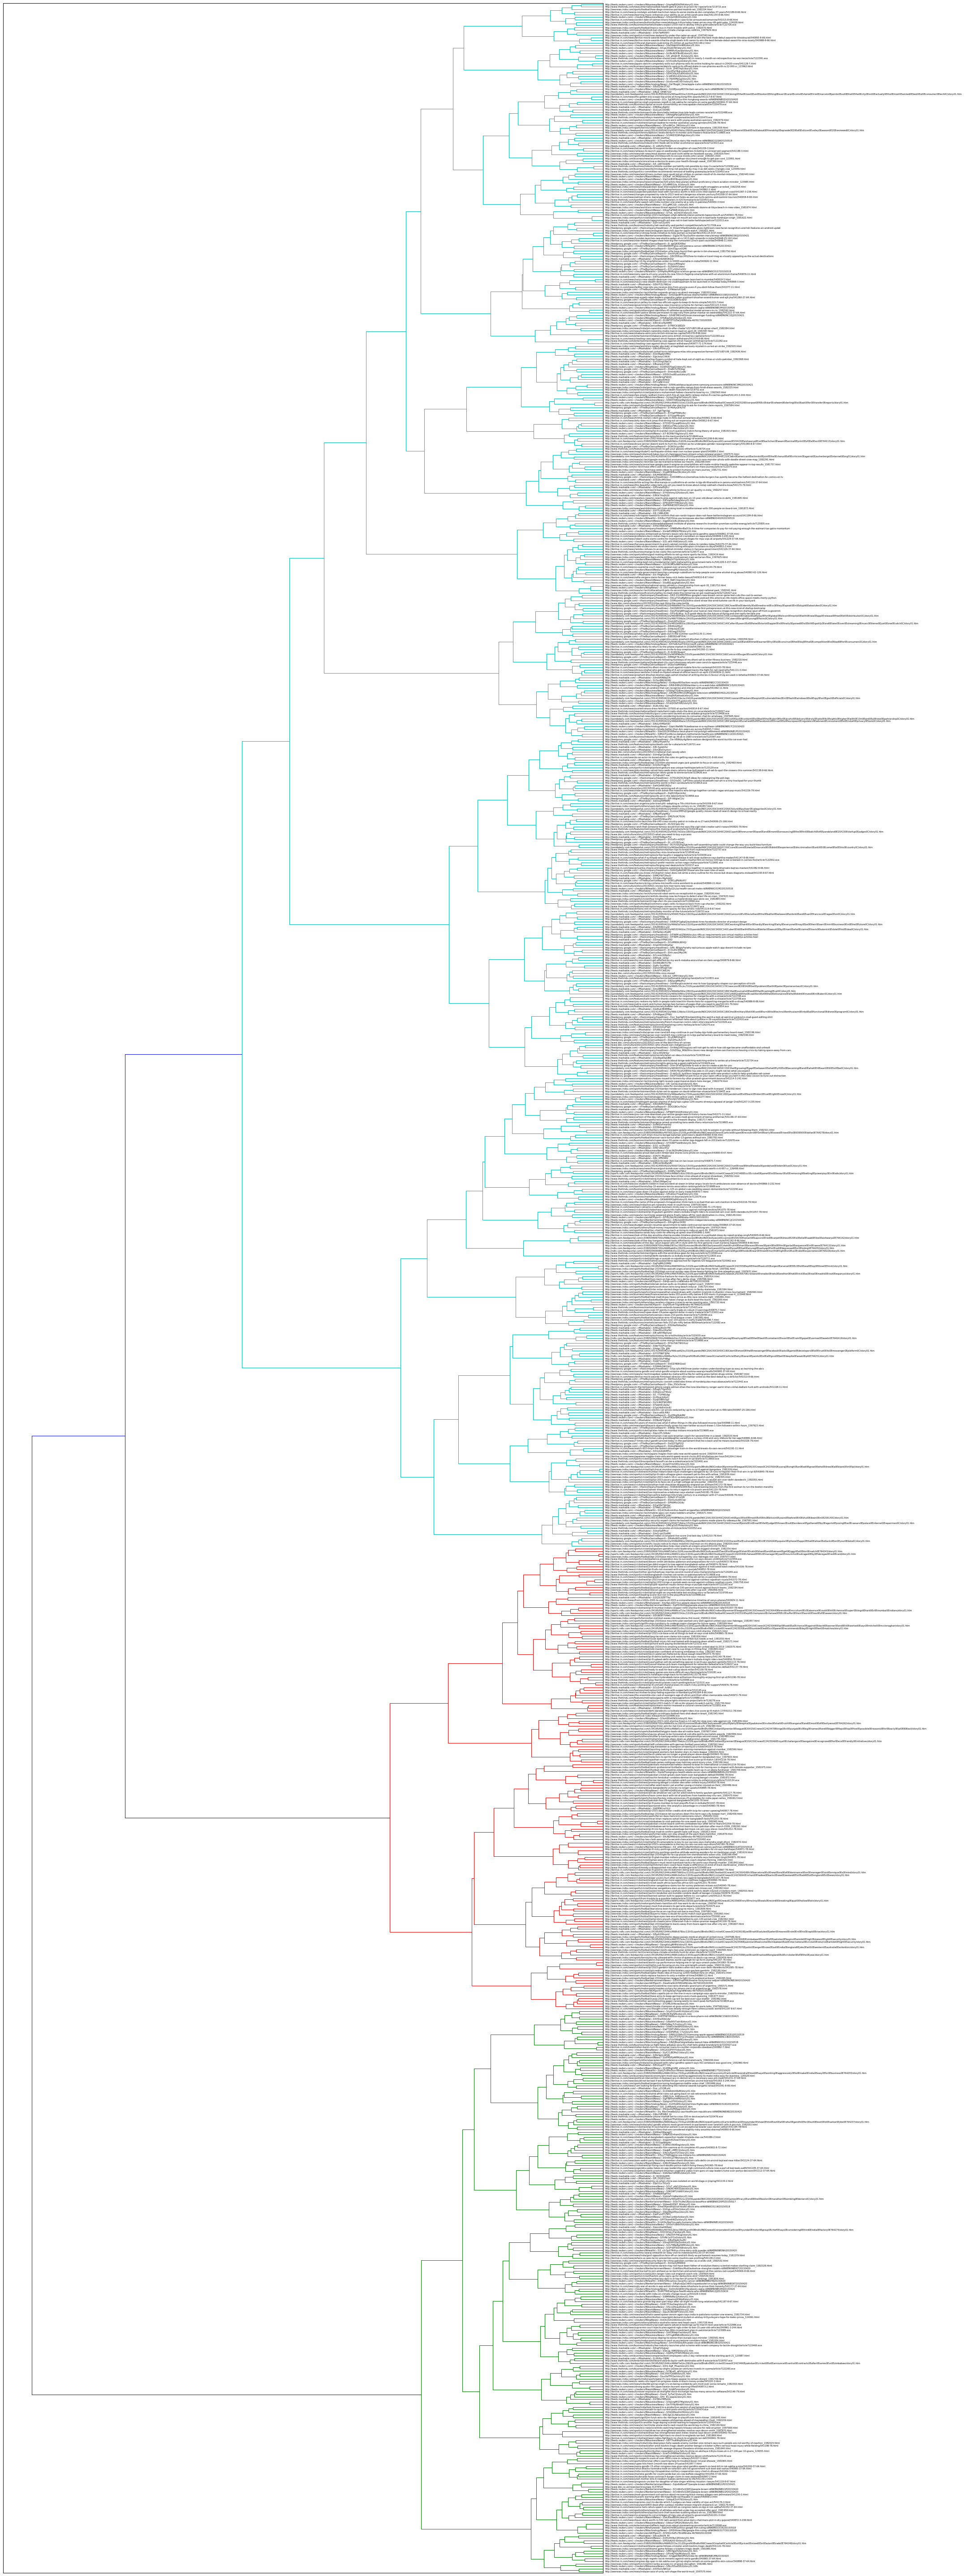

In [192]:
#apart from k-means we can use another clustering algorithm ward clustering algorithm
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(30, 80)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=link);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters


In [191]:
plt.close()